In [129]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal


## Main Functions - Inputs

In [100]:
def get_osc(t, freq, depth, t_offset):
    return depth * (np.cos(2. * np.pi * freq * (t - t_offset) / 1000.) + 1.) / 2. + (1 - depth)

#x = possible locations, spatial range
def get_gauss(x, peak_loc, width, depth=1, wrap=False):
    if wrap:
        dx = x[1] - x[0]
        length = dx * len(x)
        extended_x = np.concatenate([x - length, x, x + length])
    else:
        extended_x = x
    sigma = width / 3. / np.sqrt(2.)
    extended_rate = np.exp(-((extended_x - peak_loc) / sigma) ** 2)
    if wrap:
        rate = np.maximum(extended_rate[:len(x)], extended_rate[len(x):-len(x)])
        rate = np.maximum(rate, extended_rate[-len(x):])
    else:
        rate = extended_rate
    rate = (1. - depth) + depth * rate
    return rate


def get_spatial_osc_population_rate(t, freq, osc_depth, t_peak_locs, global_t_offset, t_spatial_width, spatial_depth,
                                    compression, peak_rate, wrap=False):
    """

    :param t: float (ms)
    :param freq: float (Hz)
    :param osc_depth: float in [0, 1]
    :param t_peak_locs: float (ms)
    :param global_t_offset: float (ms)
    :param t_spatial_width: float (s)
    :param spatial_depth: float in [0, 1]
    :param peak_rate: float (Hz)
    :param wrap: bool
    :return: 2d array of float
    """
    rate_matrix = np.empty((len(t_peak_locs), len(t)))
    for i, t_peak in enumerate(t_peak_locs):
        if compression is None:
            t_offset = global_t_offset
        else:
            t_offset = compression * t_peak + global_t_offset
        osc_rate = get_osc(t, freq, osc_depth, t_offset)
        spatial_rate = get_gauss(t, t_peak, t_spatial_width, spatial_depth, wrap)
        rate_matrix[i] = osc_rate * spatial_rate * peak_rate

    return rate_matrix

## Simulation Parameters

In [257]:
duration = 10000. # ms
dt = 1  # ms
velocity = 20.  # cm / s

t = np.arange(-duration/2., duration + duration / 2., dt)
#t = np.arange(0., duration, dt) 

In [258]:
position = t / 1000. * velocity 

global_t_offset = 0.  # ms
LFP_freq = 7 # Hz
input_freq = {'Inh': LFP_freq}
compression = {'Inh': None}

# Geisler et al., PNAS, 2010.
# cm
x_field_width = {'CA1': 60.,
                 'CA3': 60.,
                 'Inh': 60.}

#conversion from position to time..
t_field_width = {}
for pop in x_field_width:
    t_field_width[pop] = x_field_width[pop] / velocity * 1000.  # ms

input_freq['CA3'] = LFP_freq + 1. / t_field_width['CA3'] * 1000.
compression['CA3'] = 1. / (t_field_width['CA3'] / 1000. * input_freq['CA3'])

osc_depth = {'CA3': 0.7,
             'Inh': 0.5}

spatial_depth = {'CA3': 1.,
                 'Inh': 0.}

pop_size = {'CA3': 200,
            'Inh': 60}

# ms
syn_rise_tau = {'AMPA': 1., 'NMDA': 1., 'GABA': 1.}
syn_decay_tau = {'AMPA': 5., 'NMDA': 50., 'GABA': 5.}


# Hz
peak_rate = {'CA3': 40.,
             'Inh': 20.}

# mV
vm_rev = {'AMPA': 0.,
          'NMDA': 0.,
          'GABA': -70.}
#cell_tau
vm_tau = 20.  # ms
vm_rest = -68.  # mV
CA1_input_resistance = 100. # MOhm

t_peak_CA1 = duration/2  #ms 
#t position of CA1 post cell peak 


t_peak_locs = {}
for pop in pop_size:
    t_peak_locs[pop] = np.linspace(-duration/2., duration + duration / 2., pop_size[pop])

# dict with 2d array
input_rate = {}
for pop in input_freq:
    input_rate[pop] = get_spatial_osc_population_rate(t, input_freq[pop], osc_depth[pop], t_peak_locs[pop],
                                                      global_t_offset, t_field_width[pop], spatial_depth[pop],
                                                      compression[pop], peak_rate[pop])
    
#weight of the CA3 inputs that CA1 gets, weight depends on peak location of CA3 inputs
weight_CA3 = get_gauss(t_peak_locs['CA3'], t_peak_CA1, t_field_width['CA1'], depth=1, wrap=False)  
weight_Inh = get_gauss(t_peak_locs['Inh'], t_peak_CA1, t_field_width['CA1'], depth=1, wrap=False)  



CA1_baseline_weight = {'AMPA': 1. , 'NMDA': 1., 'GABA': 1.}

#how much increase above baseline - the change in weights refers to AMPA receptors (plasticity in AMPA)
CA1_d_weight = {'AMPA': 1.5, 'NMDA': 0 ,'GABA': 0} 

#weights need to be scaled for the change in weight and the baseline
weights = {'CA3':  {'AMPA': weight_CA3  * CA1_d_weight['AMPA'] + CA1_baseline_weight['AMPA']}} 

weights['CA3']['NMDA'] = weight_CA3  * CA1_d_weight['NMDA'] + CA1_baseline_weight['NMDA']

weights['Inh'] = {}
weights['Inh']['GABA'] = weight_Inh * CA1_d_weight['GABA'] + CA1_baseline_weight['GABA'] 

<IPython.core.display.Javascript object>


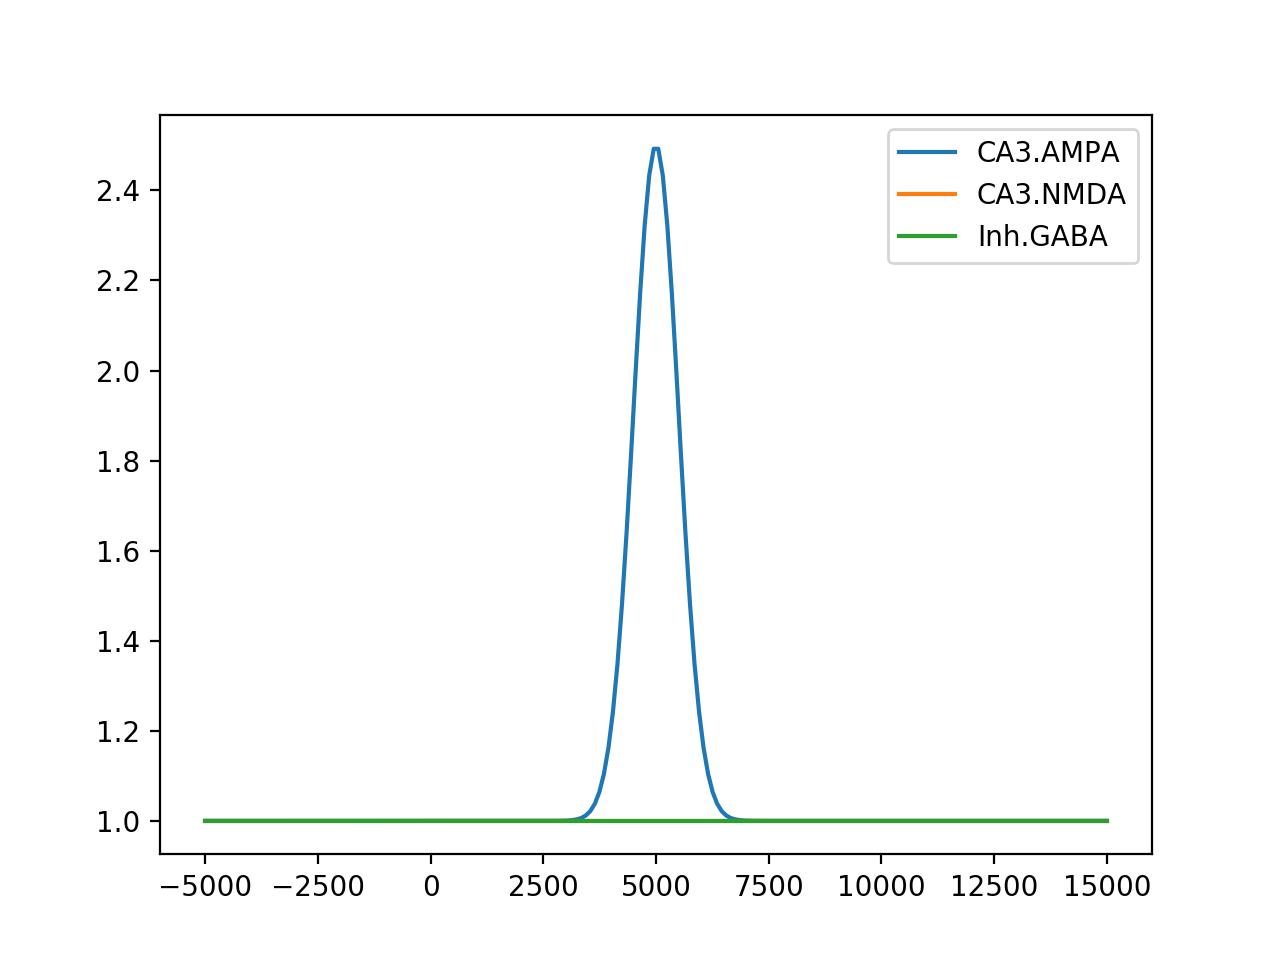

In [259]:
plt.figure()
for pop in weights:
    for syn_type in weights[pop]:
        plt.plot(t_peak_locs[pop], weights[pop][syn_type], label = '%s.%s' % (pop, syn_type))
plt.legend(loc='best')

## Conductance Based Synapse

In [260]:
def get_d_cell_voltage_dt(cell_voltage, net_current, cell_tau, input_resistance=100.):
    """
    Computes the rate of change of cellular voltage for one postsynaptic unit.
    :param cell_voltage: float (mV)
    :param net_current: float (nA)
    :param cell_tau: float (seconds)
    :param input_resistance: float (MOhm)
    :return: float (mV / ms)
    """
    d_cell_voltage_dt = (-cell_voltage + input_resistance * net_current) / cell_tau
    return d_cell_voltage_dt

#operates on a single array
def get_d_conductance_dt_array(channel_conductance, input_rate, syn_rise_tau, syn_decay_tau, scale_factor=1):
    """
    
    :param channel_conductance: 1d array of float (nS)
    :param pre_activity: 1d array of float (Hz)
    :param rise_tau: float (ms)
    :param decay_tau: float (ms)
    :param scale_factor: float (convert Hz to nS)
    :return: 1d array of float (nS / ms)
    """
    d_conductance_dt_array = -channel_conductance / syn_decay_tau + \
                             scale_factor * np.maximum(0., input_rate - channel_conductance) / syn_rise_tau
    return d_conductance_dt_array

In [261]:
def get_d_conductance_dt_dict(syn_rise_tau, syn_decay_tau, channel_conductance_dict, cell_voltage, network_activity_dict, scale_factor=1):
    
    #initial conductance will all be zero 
    d_conductance_dt_dict = {}
    for pre_population in channel_conductance_dict:  # get the change in synaptic currents for every connection
        d_conductance_dt_dict[pre_population] = {}
        for syn_type in channel_conductance_dict[pre_population]:
            this_decay_tau = syn_decay_tau[syn_type]
            this_rise_tau = syn_rise_tau[syn_type]
            this_channel_conductance = channel_conductance_dict[pre_population][syn_type]
            #want dict of 1d array (1 timestep)
            this_pre_activity = network_activity_dict[pre_population]
            d_conductance_dt_dict[pre_population][syn_type] = \
                get_d_conductance_dt_array(this_channel_conductance, this_pre_activity, this_rise_tau, this_decay_tau, scale_factor)

    return d_conductance_dt_dict 

In [262]:
def get_net_current(weights_dict, channel_conductance_dict, cell_voltage, vm_rev):
    """

    :param weights: nested dict of array of floats [pre_population][syn_type] 
    :param channel_conductances: nested dict of array of floats [pre_population][syn_type] (nS)
    :param cell_voltage: float (mV)
    :param reversal_potential: dict of floats [syn_type] (mV)
    :return: float (nA)
    """
    this_net_current = 0.
    for pre_population in weights_dict:
        for syn_type in weights_dict[pre_population]:
            this_weight_array = weights_dict[pre_population][syn_type]
            this_conductance_array = channel_conductance_dict[pre_population][syn_type]
            net_current_array = ((this_weight_array * this_conductance_array) * (vm_rev[syn_type] - cell_voltage))
            this_net_current += np.sum(net_current_array, axis=0)          
    return this_net_current 

In [263]:
equilibrate_dur = 500.  # ms

# we need a different t array with the extra track boundaries
sim_t_indexes = np.where((t >= -equilibrate_dur) & (t <= duration))[0]

# declare some data structure variables to store the sim intermediates
sim_vm = np.empty(len(sim_t_indexes))
sim_t = t[sim_t_indexes]
sim_conductance_dict = {'CA3': {'AMPA': np.empty((pop_size['CA3'], len(sim_t_indexes))), 
                                'NMDA': np.empty((pop_size['CA3'], len(sim_t_indexes)))}, 
                        'Inh': {'GABA': np.empty((pop_size['Inh'], len(sim_t_indexes)))}}

cell_voltage = vm_rest
channel_conductance_dict = {'CA3': {'AMPA': np.zeros(pop_size['CA3']), 
                                    'NMDA': np.zeros(pop_size['CA3'])}, 
                            'Inh': {'GABA': np.zeros(pop_size['Inh'])}}

for i, ti in enumerate(sim_t_indexes):
    network_activity_dict = {}
    for pop in input_rate:
        network_activity_dict[pop] = input_rate[pop][:, ti]
    
    d_conductance_dt_dict = get_d_conductance_dt_dict(syn_rise_tau, syn_decay_tau, channel_conductance_dict, cell_voltage, network_activity_dict)
    for pop in channel_conductance_dict:
        for syn_type in channel_conductance_dict[pop]:
            channel_conductance_dict[pop][syn_type] += d_conductance_dt_dict[pop][syn_type] * dt
            sim_conductance_dict[pop][syn_type][:, i] = channel_conductance_dict[pop][syn_type]
    
    net_current = get_net_current(weights, channel_conductance_dict, cell_voltage, vm_rev)
    dvdt = get_d_cell_voltage_dt(cell_voltage, net_current, vm_tau, input_resistance=CA1_input_resistance)
    
    cell_voltage += dvdt * dt
    sim_vm[i] = cell_voltage

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


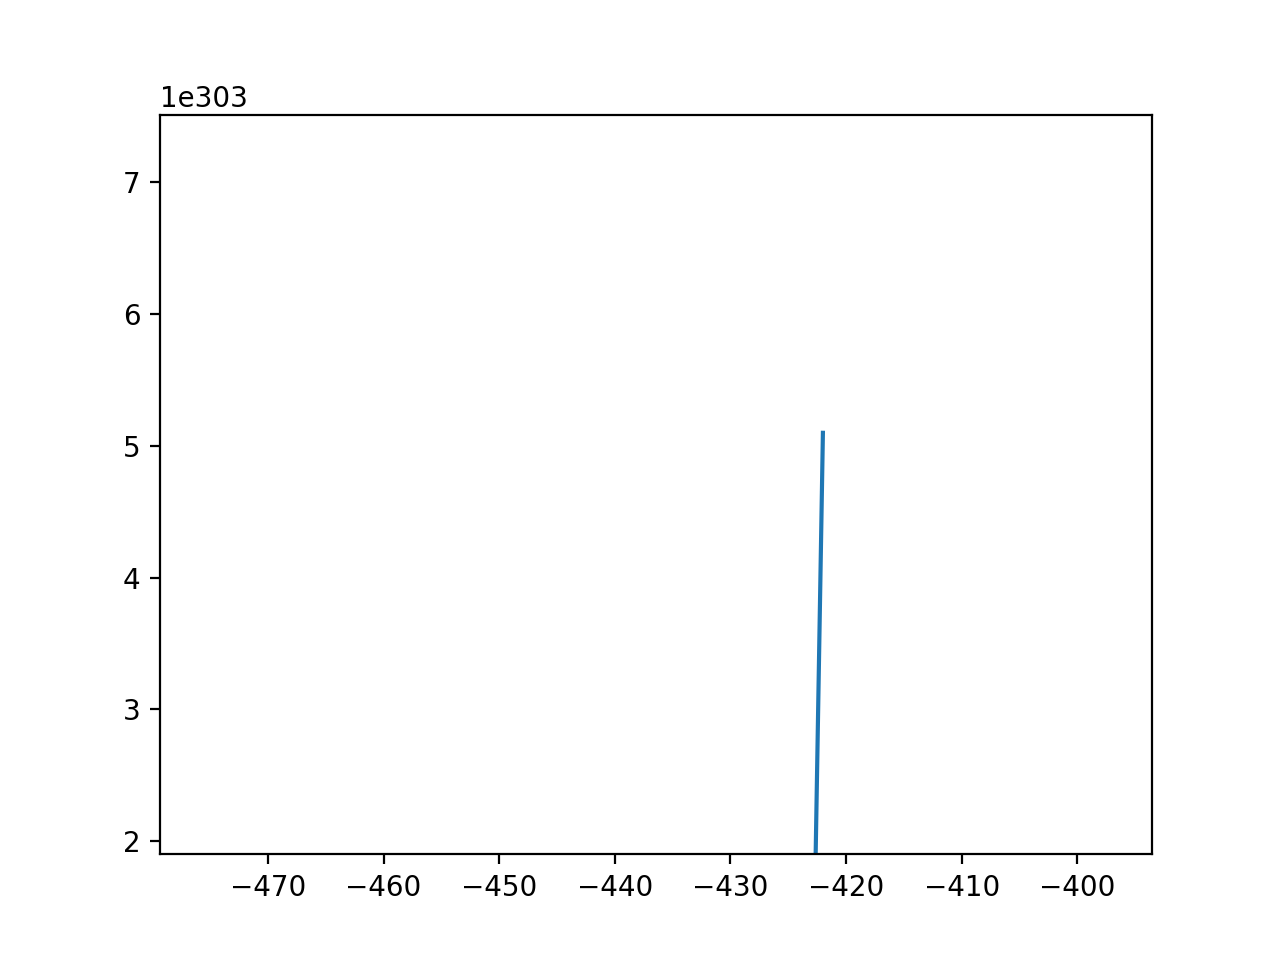

In [267]:
plt.figure()
plt.plot(sim_t, sim_vm)

In [167]:
t

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.997e+03, 9.998e+03,
       9.999e+03])